# Siamese Network with Optuna for Hyperparameter Optimization

### Install dependencies

In [1]:
%cd {HOME}

!python -m pip install opencv-python matplotlib tensorflow==2.10 

[WinError 2] 系統找不到指定的檔案。: '{HOME}'
d:\Code\CowId\notebooks


In [2]:
!conda install -c conda-forge cudatoolkit=11.8.0 --yes

Retrieving notices: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: d:\Code\CowId\.conda

  added / updated specs:
    - cudatoolkit=11.8.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-3.1.0              |       hcfcfb64_3         7.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         7.1 MB

The following packages will be UPDATED:

  openssl                                  3.1.0-hcfcfb64_2 --> 3.1.0-hcfcfb64_3 




openssl-3.1.0        | 7.1 MB    |            |   0% 
openssl-3.1.0        | 7.1 MB    | 1          |   2% 
openssl-3.1.0        | 7.1 MB    | ####4      |  44% 
openssl-3.1.0        | 7.1 MB    | #########8 |  98% 
openssl-3.1.0        | 7.1 MB    | ########## | 100% 
                                                    



==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.3.1




In [3]:
!pip install nvidia-cudnn-cu11==8.6.0.163 --yes


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --yes


In [4]:
!CUDNN_PATH=$(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/:$CUDNN_PATH/lib

'CUDNN_PATH' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC
'export' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC


In [5]:
# Check CPU
!python -c "import tensorflow as tf; print(tf.reduce_sum(tf.random.normal([1000, 1000])))"

tf.Tensor(1882.368, shape=(), dtype=float32)


2023-05-06 18:03:23.860451: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-06 18:03:24.680411: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9392 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


In [6]:
# Check GPU
!python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
!pip install optuna

### Import dependencies

In [1]:
import os
import cv2
import csv
import time
import random
import optuna
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

d:\Code\CowId\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


('2.10.0', '1.24.2')

### Set up environment

Set GPU growth to avoid OOM errors

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

Set Home path

In [3]:
HOME = os.path.split(os.getcwd())[0]
print(HOME)
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

d:\Code\CowId


Set data path

In [4]:
dataset_path = os.path.join(HOME, "data", "siamese_v4_augmented")

In [5]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

### Helper functions

In [6]:
def read_image(path, target_size=(128, 128)):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    return image

In [7]:
def generate_triplets(output_loc):
    if not os.path.exists(output_loc):
        os.makedirs(output_loc)
    triplets = []
    for cows in os.listdir(dataset_path):
        neg_dir_list = os.listdir(dataset_path)
        neg_dir_list.remove(cows)
        all_cows_except_current = []
        for neg_cows in neg_dir_list:
            neg_list = os.listdir(os.path.join(dataset_path, neg_cows))
            neg_list = list(map(lambda x: os.path.join(dataset_path, neg_cows, x), neg_list))
            all_cows_except_current = all_cows_except_current + neg_list
        path_to_cow = os.path.join(dataset_path, cows)
        print(path_to_cow)
        if "cow" in path_to_cow:
            pos_list = os.listdir(os.path.join(dataset_path,cows))
            pos_list = list(map(lambda x: os.path.join(dataset_path, cows, x), pos_list))
            while len(pos_list) > 1 and len(neg_list) > 0:
                rand_pos_index = random.randrange(len(pos_list)) 
                positive_elem = pos_list.pop(rand_pos_index)
                rand_anc_index = random.randrange(len(pos_list))
                anchor_elem = pos_list.pop(rand_anc_index)
                rand_neg_index = random.randrange(len(neg_list))
                neg_elem = neg_list.pop(rand_neg_index)
                triplets.append((positive_elem,anchor_elem,neg_elem))  
    print(len(triplets))
    with open(os.path.join(output_loc, 'triplets.csv'), 'w', newline='') as file:
        writer = csv.writer(file)
        for row in triplets:
            writer.writerow(row)

In [8]:
def split_dataset(saving_route, percentage=0.2):
    dataset = []
    with open(os.path.join(saving_route, 'triplets.csv'), newline='') as file:
        reader = csv.reader(file)
        for row in reader:
            dataset.append(row)
    n = len(dataset)
    split_point = int(n * percentage)
    random.shuffle(dataset)
    train_set = dataset[:split_point] 
    test_set = dataset[split_point:]
    return train_set, test_set

In [9]:
def get_batch(triplet_list, batch_size=64, preprocess=True):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1
            
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        
        yield ([anchor, positive, negative])

In [10]:
def get_encoder(input_shape):

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    
    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

In [11]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [12]:
def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoded_a,
        encoded_p,
        encoded_n
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

In [13]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [14]:
def test_on_triplets(val_triplets, siamese_model, batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(val_triplets, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [15]:
def plot_metrics(loss, metrics, dir):
    plt.clf()
    # Extracting individual metrics from metrics
    accuracy = metrics[:, 0]
    ap_mean  = metrics[:, 1]
    an_mean  = metrics[:, 2]
    ap_stds  = metrics[:, 3]
    an_stds  = metrics[:, 4]
    
    plt.figure(figsize=(15,5))
    
    # Plotting the loss over epochs
    plt.subplot(121)
    plt.plot(loss, 'b', label='Loss')
    plt.title('Training loss')
    plt.legend()
    plt.savefig(os.path.join(dir, 'Loss.png'))
    plt.clf()
    
    # Plotting the accuracy over epochs
    plt.subplot(122)
    plt.plot(accuracy, 'r', label='Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()
    plt.savefig(os.path.join(dir, 'Accuracy.png'))
    
    plt.figure(figsize=(15,5))
    plt.clf()
    
    # Comparing the Means over epochs
    plt.subplot(121)
    plt.plot(ap_mean, 'b', label='AP Mean')
    plt.plot(an_mean, 'g', label='AN Mean')
    plt.title('Means Comparision')
    plt.legend()
    
    # Plotting the accuracy
    ap_75quartile = (ap_mean+ap_stds)
    an_75quartile = (an_mean-an_stds)
    plt.subplot(122)
    plt.plot(ap_75quartile, 'b', label='AP (Mean+SD)')
    plt.plot(an_75quartile, 'g', label='AN (Mean-SD)')
    plt.title('75th Quartile Comparision')
    plt.legend()
    plt.savefig(os.path.join(dir, 'metrics.png'))
    plt.clf()

In [16]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

In [17]:
def classify_images(encoder, cows_list1, cows_list2, threshold=0.5):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(cows_list1)
    tensor2 = encoder.predict(cows_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    print(prediction)
    return prediction

In [18]:
def ModelMetrics(pos_list, neg_list, dir):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.clf()
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    plt.savefig(os.path.join(dir, 'confusion_matrix.png'))
    plt.clf()
    return accuracy_score(true, pred), f1_score(true, pred)

In [19]:
def preprocess(img):
    img = tf.image.resize(img, (128,128))
    img = img / 255.0
    return img

In [20]:
def classify_image(encoder, cow1, cow2, threshold=0.5):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(np.array([cow1]))
    tensor2 = encoder.predict(np.array([cow2]))
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    return distance[0]

In [21]:
saving_route = os.path.join(HOME, 'data', 'siamese_triplets_lists')

generate_triplets(saving_route)

train_triplets, val_triplets = split_dataset(saving_route, 0.2)

d:\Code\CowId\data\siamese_v4_augmented\cow_1
d:\Code\CowId\data\siamese_v4_augmented\cow_2
d:\Code\CowId\data\siamese_v4_augmented\cow_3
d:\Code\CowId\data\siamese_v4_augmented\cow_4
d:\Code\CowId\data\siamese_v4_augmented\cow_5
d:\Code\CowId\data\siamese_v4_augmented\cow_6
d:\Code\CowId\data\siamese_v4_augmented\cow_7
d:\Code\CowId\data\siamese_v4_augmented\cow_8
d:\Code\CowId\data\siamese_v4_augmented\negatives
7385


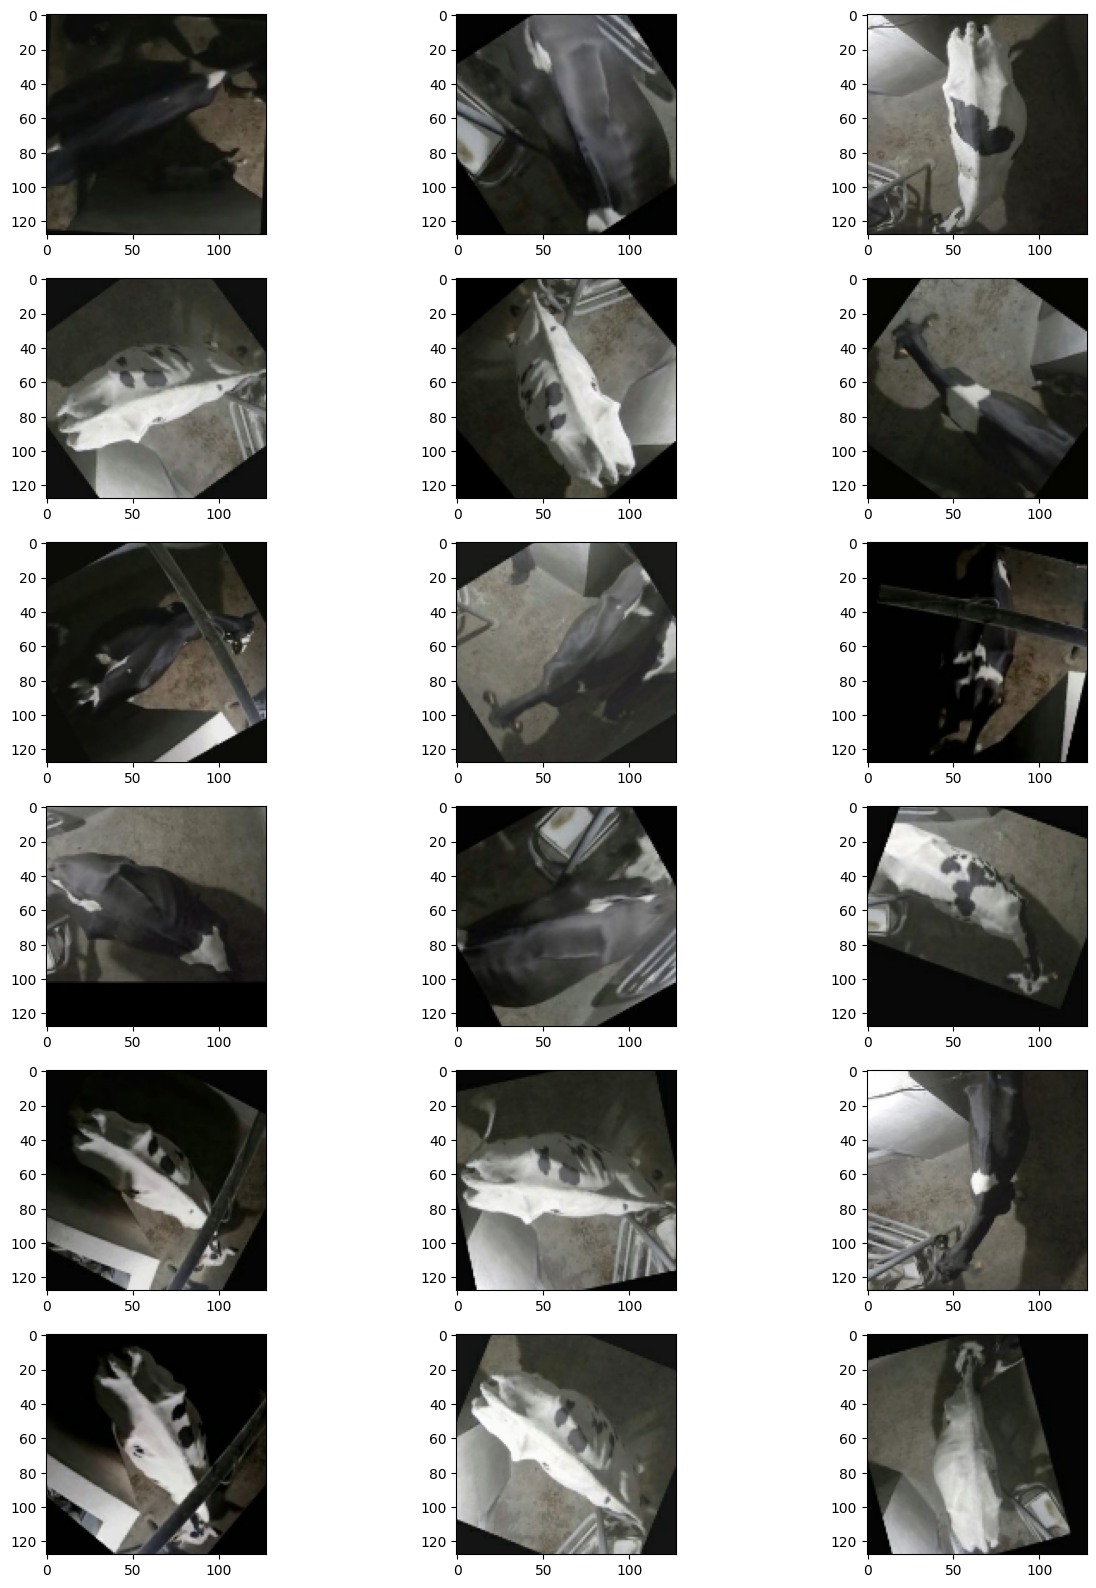

In [22]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplets, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
    break

In [23]:
folder_names = [name for name in os.listdir(os.path.join(HOME, 'data', 'optuna_siamese')) if os.path.isdir(os.path.join(HOME, 'data', 'optuna_siamese', name))]
sorted_folders = sorted(folder_names, reverse=True)

OPTUNA_RUN_ITERATION = 0 if len(sorted_folders) == 0 else int(sorted_folders[0])

def objective(trial):
    global OPTUNA_RUN_ITERATION
    OPTUNA_RUN_ITERATION += 1
    OPTUNA_DIR = os.path.join(HOME, 'data', 'optuna_siamese', str(OPTUNA_RUN_ITERATION))

    if not os.path.exists(os.path.join(HOME, 'data', OPTUNA_DIR)):
        os.makedirs(os.path.join(HOME, 'data', OPTUNA_DIR))

    param_grid = {"LR": trial.suggest_int("LR", -4, -3, step=1), 
                  'E': trial.suggest_int("E", -3, -2, step=1), 
                  'EPOCHS': trial.suggest_int("EPOCHS", 30, 50, step=10),
                  'BATCH_SIZE': trial.suggest_int("BATCH_SIZE", 32, 64, step=32)}

    LR = 10**param_grid["LR"]
    E = 10**param_grid["E"]
    EPOCHS = param_grid["EPOCHS"]
    BATCH_SIZE = param_grid["BATCH_SIZE"]

    with open(os.path.join(HOME, 'data', OPTUNA_DIR, 'params.json'), 'w') as f:
        json.dump(param_grid, f)

    save_all = False

    siamese_network = get_siamese_network()
    siamese_model = SiameseModel(siamese_network)
    optimizer = Adam(learning_rate=LR, epsilon=E)
    siamese_model.compile(optimizer=optimizer)

    max_acc = 0
    train_loss = []
    test_metrics = []

    for epoch in range(1, EPOCHS+1):
        t = time.time()
        print(f"Started training EPOCH {epoch}")
        
        # Training the model on train data
        epoch_loss = []
        for data in get_batch(train_triplets, batch_size=BATCH_SIZE):
            loss = siamese_model.train_on_batch(data)
            epoch_loss.append(loss)
        epoch_loss = sum(epoch_loss)/len(epoch_loss)
        train_loss.append(epoch_loss)

        print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
        print(f"Loss on train    = {epoch_loss:.5f}")
        
        # Testing the model on test data
        metric = test_on_triplets(val_triplets, siamese_model, batch_size=BATCH_SIZE)
        test_metrics.append(metric)
        accuracy = metric[0]
        
        # Saving the model weights
        if save_all or accuracy>=max_acc:
            siamese_model.save_weights(os.path.join(OPTUNA_DIR, "siamese_model"))
            max_acc = accuracy

    # Saving the model after all epochs run
    siamese_model.save_weights(os.path.join(OPTUNA_DIR, "siamese_model-final"))

    test_metrics = np.array(test_metrics)
    plot_metrics(train_loss, test_metrics, os.path.join(OPTUNA_DIR))

    encoder = extract_encoder(siamese_model)
    encoder.save_weights(os.path.join(OPTUNA_DIR, "encoder"))

    pos_list = np.array([])
    neg_list = np.array([])

    for data in get_batch(val_triplets, batch_size=64):
        a, p, n = data
        pos_list = np.append(pos_list, classify_images(encoder, a, p, 0.3))
        neg_list = np.append(neg_list, classify_images(encoder, a, n, 0.3))

    model_accuracy, model_f1 = ModelMetrics(pos_list, neg_list, os.path.join(OPTUNA_DIR))

    encoder.save(os.path.join(OPTUNA_DIR, 'siamese_model.h5'))

    return model_accuracy, model_f1


[I 2023-05-07 23:40:22,520] A new study created in RDB with name: no-name-00de0992-4e9c-483a-8b84-f3400b66c822


Started training EPOCH 1

EPOCH: 1 	 (Epoch done in 36 sec)
Loss on train    = 0.77512
1/1 [==============================] - 1s 930ms/step
Accuracy on test = 0.82092
Started training EPOCH 2

EPOCH: 2 	 (Epoch done in 4 sec)
Loss on train    = 0.40271
1/1 [==============================] - 0s 17ms/step
Accuracy on test = 0.90944
Started training EPOCH 3

EPOCH: 3 	 (Epoch done in 4 sec)
Loss on train    = 0.21514
1/1 [==============================] - 0s 18ms/step
Accuracy on test = 0.95091
Started training EPOCH 4

EPOCH: 4 	 (Epoch done in 4 sec)
Loss on train    = 0.11160
1/1 [==============================] - 0s 17ms/step
Accuracy on test = 0.96581
Started training EPOCH 5

EPOCH: 5 	 (Epoch done in 4 sec)
Loss on train    = 0.05305
1/1 [==============================] - 0s 17ms/step
Accuracy on test = 0.96750
Started training EPOCH 6

EPOCH: 6 	 (Epoch done in 4 sec)
Loss on train    = 0.02749
1/1 [==============================] - 0s 17ms/step
Accuracy on test = 0.97681
Started 

[I 2023-05-07 23:54:13,481] Trial 0 finished with values: [0.5974102911306702, 0.7128629202631737] and parameters: {'LR': -4, 'E': -2, 'EPOCHS': 30, 'BATCH_SIZE': 64}. 


Started training EPOCH 1

EPOCH: 1 	 (Epoch done in 10 sec)
Loss on train    = 0.40767
1/1 [==============================] - 1s 843ms/step
Accuracy on test = 0.94465
Started training EPOCH 2

EPOCH: 2 	 (Epoch done in 5 sec)
Loss on train    = 0.13264
1/1 [==============================] - 0s 18ms/step
Accuracy on test = 0.95193
Started training EPOCH 3

EPOCH: 3 	 (Epoch done in 5 sec)
Loss on train    = 0.08795
1/1 [==============================] - 0s 17ms/step
Accuracy on test = 0.96936
Started training EPOCH 4

EPOCH: 4 	 (Epoch done in 4 sec)
Loss on train    = 0.05796
1/1 [==============================] - 0s 17ms/step
Accuracy on test = 0.98087
Started training EPOCH 5

EPOCH: 5 	 (Epoch done in 4 sec)
Loss on train    = 0.05880
1/1 [==============================] - 0s 19ms/step
Accuracy on test = 0.97952
Started training EPOCH 6

EPOCH: 6 	 (Epoch done in 4 sec)
Loss on train    = 0.04896
1/1 [==============================] - 0s 17ms/step
Accuracy on test = 0.97156
Started 

[I 2023-05-08 00:09:43,799] Trial 1 finished with values: [0.8996276235612729, 0.9079478422850047] and parameters: {'LR': -3, 'E': -2, 'EPOCHS': 30, 'BATCH_SIZE': 32}. 


Started training EPOCH 1

EPOCH: 1 	 (Epoch done in 11 sec)
Loss on train    = 0.39628
1/1 [==============================] - 1s 862ms/step
Accuracy on test = 0.91368
Started training EPOCH 2

EPOCH: 2 	 (Epoch done in 6 sec)
Loss on train    = 0.15512
1/1 [==============================] - 0s 18ms/step
Accuracy on test = 0.96141
Started training EPOCH 3

EPOCH: 3 	 (Epoch done in 6 sec)
Loss on train    = 0.10625
1/1 [==============================] - 0s 19ms/step
Accuracy on test = 0.94482
Started training EPOCH 4

EPOCH: 4 	 (Epoch done in 5 sec)
Loss on train    = 0.06676
1/1 [==============================] - 0s 18ms/step
Accuracy on test = 0.97427
Started training EPOCH 5

EPOCH: 5 	 (Epoch done in 6 sec)
Loss on train    = 0.04503
1/1 [==============================] - 0s 18ms/step
Accuracy on test = 0.97918
Started training EPOCH 6

EPOCH: 6 	 (Epoch done in 6 sec)
Loss on train    = 0.02853
1/1 [==============================] - 0s 19ms/step
Accuracy on test = 0.97258
Started 

[I 2023-05-08 00:37:24,009] Trial 2 finished with values: [0.9564150304671631, 0.9574133796411147] and parameters: {'LR': -3, 'E': -2, 'EPOCHS': 40, 'BATCH_SIZE': 32}. 


Started training EPOCH 1

EPOCH: 1 	 (Epoch done in 12 sec)
Loss on train    = 0.67401
1/1 [==============================] - 1s 951ms/step
Accuracy on test = 0.88490
Started training EPOCH 2

EPOCH: 2 	 (Epoch done in 7 sec)
Loss on train    = 0.25159
1/1 [==============================] - 0s 21ms/step
Accuracy on test = 0.95802
Started training EPOCH 3

EPOCH: 3 	 (Epoch done in 7 sec)
Loss on train    = 0.09571
1/1 [==============================] - 0s 20ms/step
Accuracy on test = 0.97343
Started training EPOCH 4

EPOCH: 4 	 (Epoch done in 7 sec)
Loss on train    = 0.04160
1/1 [==============================] - 0s 20ms/step
Accuracy on test = 0.97021
Started training EPOCH 5

EPOCH: 5 	 (Epoch done in 7 sec)
Loss on train    = 0.02560
1/1 [==============================] - 0s 24ms/step
Accuracy on test = 0.97867
Started training EPOCH 6

EPOCH: 6 	 (Epoch done in 7 sec)
Loss on train    = 0.01335
1/1 [==============================] - 0s 19ms/step
Accuracy on test = 0.97952
Started 

[I 2023-05-08 01:12:20,592] Trial 3 finished with values: [0.6478503723764387, 0.7392040112817299] and parameters: {'LR': -4, 'E': -3, 'EPOCHS': 50, 'BATCH_SIZE': 64}. 


Started training EPOCH 1

EPOCH: 1 	 (Epoch done in 15 sec)
Loss on train    = 0.40100
1/1 [==============================] - 1s 989ms/step
Accuracy on test = 0.95447
Started training EPOCH 2

EPOCH: 2 	 (Epoch done in 11 sec)
Loss on train    = 0.11781
1/1 [==============================] - 0s 20ms/step
Accuracy on test = 0.94787
Started training EPOCH 3

EPOCH: 3 	 (Epoch done in 10 sec)
Loss on train    = 0.08795
1/1 [==============================] - 0s 21ms/step
Accuracy on test = 0.97343
Started training EPOCH 4

EPOCH: 4 	 (Epoch done in 10 sec)
Loss on train    = 0.05570
1/1 [==============================] - 0s 21ms/step
Accuracy on test = 0.98087
Started training EPOCH 5

EPOCH: 5 	 (Epoch done in 10 sec)
Loss on train    = 0.04499
1/1 [==============================] - 0s 20ms/step
Accuracy on test = 0.98020
Started training EPOCH 6

EPOCH: 6 	 (Epoch done in 10 sec)
Loss on train    = 0.02661
1/1 [==============================] - 0s 22ms/step
Accuracy on test = 0.98494
Sta

[I 2023-05-08 01:42:59,076] Trial 4 finished with values: [0.9360189573459715, 0.9385165907612232] and parameters: {'LR': -3, 'E': -2, 'EPOCHS': 30, 'BATCH_SIZE': 32}. 


Started training EPOCH 1

EPOCH: 1 	 (Epoch done in 15 sec)
Loss on train    = 0.80341
1/1 [==============================] - 1s 1s/step
Accuracy on test = 0.79926
Started training EPOCH 2

EPOCH: 2 	 (Epoch done in 9 sec)
Loss on train    = 0.44418
1/1 [==============================] - 0s 23ms/step
Accuracy on test = 0.90030
Started training EPOCH 3

EPOCH: 3 	 (Epoch done in 9 sec)
Loss on train    = 0.23747
1/1 [==============================] - 0s 29ms/step
Accuracy on test = 0.94414
Started training EPOCH 4

EPOCH: 4 	 (Epoch done in 9 sec)
Loss on train    = 0.12133
1/1 [==============================] - 0s 23ms/step
Accuracy on test = 0.96378
Started training EPOCH 5

EPOCH: 5 	 (Epoch done in 9 sec)
Loss on train    = 0.06353
1/1 [==============================] - 0s 23ms/step
Accuracy on test = 0.96767
Started training EPOCH 6

EPOCH: 6 	 (Epoch done in 9 sec)
Loss on train    = 0.03487
1/1 [==============================] - 0s 23ms/step
Accuracy on test = 0.96361
Started tra

[I 2023-05-08 02:10:17,560] Trial 5 finished with values: [0.5600033852403521, 0.6944101569388115] and parameters: {'LR': -4, 'E': -2, 'EPOCHS': 30, 'BATCH_SIZE': 64}. 


Started training EPOCH 1

EPOCH: 1 	 (Epoch done in 18 sec)
Loss on train    = 0.72384
1/1 [==============================] - 1s 1s/step
Accuracy on test = 0.84970
Started training EPOCH 2

EPOCH: 2 	 (Epoch done in 12 sec)
Loss on train    = 0.31511
1/1 [==============================] - 0s 24ms/step
Accuracy on test = 0.94550
Started training EPOCH 3

EPOCH: 3 	 (Epoch done in 12 sec)
Loss on train    = 0.14226
1/1 [==============================] - 0s 27ms/step
Accuracy on test = 0.96835
Started training EPOCH 4

EPOCH: 4 	 (Epoch done in 13 sec)
Loss on train    = 0.06733
1/1 [==============================] - 0s 25ms/step
Accuracy on test = 0.97749
Started training EPOCH 5

EPOCH: 5 	 (Epoch done in 13 sec)
Loss on train    = 0.03341
1/1 [==============================] - 0s 24ms/step
Accuracy on test = 0.98206
Started training EPOCH 6

EPOCH: 6 	 (Epoch done in 13 sec)
Loss on train    = 0.01556
1/1 [==============================] - 0s 23ms/step
Accuracy on test = 0.98358
Starte

[I 2023-05-08 03:15:42,487] Trial 6 finished with values: [0.6896580907244414, 0.762699799391704] and parameters: {'LR': -4, 'E': -2, 'EPOCHS': 50, 'BATCH_SIZE': 32}. 


Started training EPOCH 1

EPOCH: 1 	 (Epoch done in 24 sec)
Loss on train    = 0.39505
1/1 [==============================] - 1s 1s/step
Accuracy on test = 0.87373
Started training EPOCH 2

EPOCH: 2 	 (Epoch done in 16 sec)
Loss on train    = 0.19248
1/1 [==============================] - 0s 32ms/step
Accuracy on test = 0.93788
Started training EPOCH 3

EPOCH: 3 	 (Epoch done in 17 sec)
Loss on train    = 0.11277
1/1 [==============================] - 0s 31ms/step
Accuracy on test = 0.95142
Started training EPOCH 4

EPOCH: 4 	 (Epoch done in 17 sec)
Loss on train    = 0.09452
1/1 [==============================] - 0s 31ms/step
Accuracy on test = 0.94194
Started training EPOCH 5

EPOCH: 5 	 (Epoch done in 18 sec)
Loss on train    = 0.08801
1/1 [==============================] - 0s 34ms/step
Accuracy on test = 0.95498
Started training EPOCH 6

EPOCH: 6 	 (Epoch done in 18 sec)
Loss on train    = 0.06787
1/1 [==============================] - 0s 32ms/step
Accuracy on test = 0.97089
Starte

[I 2023-05-08 04:23:38,033] Trial 7 finished with values: [0.900727826675694, 0.9076596079666222] and parameters: {'LR': -3, 'E': -3, 'EPOCHS': 40, 'BATCH_SIZE': 32}. 


Started training EPOCH 1

EPOCH: 1 	 (Epoch done in 26 sec)
Loss on train    = 0.44219
1/1 [==============================] - 1s 1s/step
Accuracy on test = 0.93737
Started training EPOCH 2

EPOCH: 2 	 (Epoch done in 20 sec)
Loss on train    = 0.13893
1/1 [==============================] - 0s 35ms/step
Accuracy on test = 0.95481
Started training EPOCH 3

EPOCH: 3 	 (Epoch done in 21 sec)
Loss on train    = 0.07705
1/1 [==============================] - 0s 35ms/step
Accuracy on test = 0.96970
Started training EPOCH 4

EPOCH: 4 	 (Epoch done in 18 sec)
Loss on train    = 0.04638
1/1 [==============================] - 0s 37ms/step
Accuracy on test = 0.97563
Started training EPOCH 5

EPOCH: 5 	 (Epoch done in 18 sec)
Loss on train    = 0.04954
1/1 [==============================] - 0s 37ms/step
Accuracy on test = 0.97884
Started training EPOCH 6

EPOCH: 6 	 (Epoch done in 20 sec)
Loss on train    = 0.02369
1/1 [==============================] - 0s 34ms/step
Accuracy on test = 0.97935
Starte

[I 2023-05-08 05:55:04,929] Trial 8 finished with values: [0.9200236966824644, 0.9248389405869721] and parameters: {'LR': -3, 'E': -2, 'EPOCHS': 50, 'BATCH_SIZE': 64}. 


Started training EPOCH 1

EPOCH: 1 	 (Epoch done in 30 sec)
Loss on train    = 0.37877
1/1 [==============================] - 1s 1s/step
Accuracy on test = 0.92806
Started training EPOCH 2

EPOCH: 2 	 (Epoch done in 22 sec)
Loss on train    = 0.14934
1/1 [==============================] - 0s 40ms/step
Accuracy on test = 0.96141
Started training EPOCH 3

EPOCH: 3 	 (Epoch done in 22 sec)
Loss on train    = 0.08419
1/1 [==============================] - 0s 41ms/step
Accuracy on test = 0.95227
Started training EPOCH 4

EPOCH: 4 	 (Epoch done in 22 sec)
Loss on train    = 0.05117
1/1 [==============================] - 0s 44ms/step
Accuracy on test = 0.97850
Started training EPOCH 5

EPOCH: 5 	 (Epoch done in 23 sec)
Loss on train    = 0.06021
1/1 [==============================] - 0s 42ms/step
Accuracy on test = 0.96259
Started training EPOCH 6

EPOCH: 6 	 (Epoch done in 22 sec)
Loss on train    = 0.04807
1/1 [==============================] - 0s 39ms/step
Accuracy on test = 0.97867
Starte

C:\Users\arihs\AppData\Local\Temp\ipykernel_21604\1431892912.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15,5))


2/2 [==============================] - 0s 17ms/step
[0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0]
2/2 [==============================] - 0s 18ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
2/2 [==============================] - 0s 15ms/step
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0
 0 0 0 1 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1]
2/2 [==============================] - 0s 17ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]
2/2 [==============================] - 0s 18ms/step
[0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 1
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 0 1]
2/2 [==============================] - 0s 19ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

[I 2023-05-08 06:57:47,573] Trial 9 finished with values: [0.8785545023696683, 0.8901309241252584] and parameters: {'LR': -3, 'E': -3, 'EPOCHS': 30, 'BATCH_SIZE': 64}. 


Started training EPOCH 1

EPOCH: 1 	 (Epoch done in 32 sec)
Loss on train    = 0.72223
1/1 [==============================] - 1s 1s/step
Accuracy on test = 0.85664
Started training EPOCH 2

EPOCH: 2 	 (Epoch done in 28 sec)
Loss on train    = 0.31961
1/1 [==============================] - 0s 40ms/step
Accuracy on test = 0.94211
Started training EPOCH 3

EPOCH: 3 	 (Epoch done in 28 sec)
Loss on train    = 0.14135
1/1 [==============================] - 0s 46ms/step
Accuracy on test = 0.96615
Started training EPOCH 4

EPOCH: 4 	 (Epoch done in 28 sec)
Loss on train    = 0.06619
1/1 [==============================] - 0s 39ms/step
Accuracy on test = 0.97156
Started training EPOCH 5

EPOCH: 5 	 (Epoch done in 25 sec)
Loss on train    = 0.03065
1/1 [==============================] - 0s 43ms/step
Accuracy on test = 0.97393
Started training EPOCH 6

EPOCH: 6 	 (Epoch done in 28 sec)
Loss on train    = 0.01416
1/1 [==============================] - 0s 43ms/step
Accuracy on test = 0.98020
Starte

[I 2023-05-08 08:43:39,263] Trial 10 finished with values: [0.7183480027081923, 0.7796610169491526] and parameters: {'LR': -4, 'E': -2, 'EPOCHS': 40, 'BATCH_SIZE': 32}. 


Started training EPOCH 1

EPOCH: 1 	 (Epoch done in 39 sec)
Loss on train    = 0.44290
1/1 [==============================] - 2s 2s/step
Accuracy on test = 0.93771
Started training EPOCH 2

EPOCH: 2 	 (Epoch done in 33 sec)
Loss on train    = 0.15617
1/1 [==============================] - 0s 46ms/step
Accuracy on test = 0.95768
Started training EPOCH 3

EPOCH: 3 	 (Epoch done in 33 sec)
Loss on train    = 0.09825
1/1 [==============================] - 0s 51ms/step
Accuracy on test = 0.97343
Started training EPOCH 4

EPOCH: 4 	 (Epoch done in 33 sec)
Loss on train    = 0.04576
1/1 [==============================] - 0s 52ms/step
Accuracy on test = 0.97139
Started training EPOCH 5

EPOCH: 5 	 (Epoch done in 33 sec)
Loss on train    = 0.04440
1/1 [==============================] - 0s 50ms/step
Accuracy on test = 0.98341
Started training EPOCH 6

EPOCH: 6 	 (Epoch done in 33 sec)
Loss on train    = 0.02015
1/1 [==============================] - 0s 47ms/step
Accuracy on test = 0.97817
Starte

[I 2023-05-08 10:34:44,615] Trial 11 finished with values: [0.9182464454976303, 0.9235275490816973] and parameters: {'LR': -3, 'E': -2, 'EPOCHS': 30, 'BATCH_SIZE': 64}. 


Started training EPOCH 1

EPOCH: 1 	 (Epoch done in 51 sec)
Loss on train    = 0.74798
1/1 [==============================] - 2s 2s/step
Accuracy on test = 0.82261
Started training EPOCH 2

EPOCH: 2 	 (Epoch done in 48 sec)
Loss on train    = 0.40465
1/1 [==============================] - 0s 56ms/step
Accuracy on test = 0.90420
Started training EPOCH 3

EPOCH: 3 	 (Epoch done in 44 sec)
Loss on train    = 0.21377
1/1 [==============================] - 0s 62ms/step
Accuracy on test = 0.95193
Started training EPOCH 4

EPOCH: 4 	 (Epoch done in 39 sec)
Loss on train    = 0.10398
1/1 [==============================] - 0s 55ms/step
Accuracy on test = 0.96953
Started training EPOCH 5

EPOCH: 5 	 (Epoch done in 41 sec)
Loss on train    = 0.05028
1/1 [==============================] - 0s 73ms/step
Accuracy on test = 0.97139
Started training EPOCH 6

EPOCH: 6 	 (Epoch done in 37 sec)
Loss on train    = 0.02757
1/1 [==============================] - 0s 61ms/step
Accuracy on test = 0.97190
Starte

[I 2023-05-08 12:36:23,644] Trial 12 finished with values: [0.6011340555179417, 0.7145885060255556] and parameters: {'LR': -4, 'E': -2, 'EPOCHS': 30, 'BATCH_SIZE': 64}. 


Started training EPOCH 1

EPOCH: 1 	 (Epoch done in 50 sec)
Loss on train    = 0.67846
1/1 [==============================] - 2s 2s/step
Accuracy on test = 0.86967
Started training EPOCH 2

EPOCH: 2 	 (Epoch done in 41 sec)
Loss on train    = 0.27841
1/1 [==============================] - 0s 49ms/step
Accuracy on test = 0.95091
Started training EPOCH 3

EPOCH: 3 	 (Epoch done in 38 sec)
Loss on train    = 0.11152
1/1 [==============================] - 0s 52ms/step
Accuracy on test = 0.97241
Started training EPOCH 4

EPOCH: 4 	 (Epoch done in 37 sec)
Loss on train    = 0.04338
1/1 [==============================] - 0s 54ms/step
Accuracy on test = 0.96919
Started training EPOCH 5

EPOCH: 5 	 (Epoch done in 37 sec)
Loss on train    = 0.02281
1/1 [==============================] - 0s 50ms/step
Accuracy on test = 0.97952
Started training EPOCH 6

EPOCH: 6 	 (Epoch done in 33 sec)
Loss on train    = 0.01130
1/1 [==============================] - 0s 55ms/step
Accuracy on test = 0.98341
Starte

[I 2023-05-08 14:25:16,635] Trial 13 finished with values: [0.629062288422478, 0.7292271575956014] and parameters: {'LR': -4, 'E': -3, 'EPOCHS': 30, 'BATCH_SIZE': 64}. 


Started training EPOCH 1

EPOCH: 1 	 (Epoch done in 51 sec)
Loss on train    = 0.44433
1/1 [==============================] - 2s 2s/step
Accuracy on test = 0.89980
Started training EPOCH 2

EPOCH: 2 	 (Epoch done in 40 sec)
Loss on train    = 0.15166
1/1 [==============================] - 0s 98ms/step
Accuracy on test = 0.96310
Started training EPOCH 3

EPOCH: 3 	 (Epoch done in 51 sec)
Loss on train    = 0.06802
1/1 [==============================] - 0s 64ms/step
Accuracy on test = 0.97224
Started training EPOCH 4

EPOCH: 4 	 (Epoch done in 43 sec)
Loss on train    = 0.04282
1/1 [==============================] - 0s 64ms/step
Accuracy on test = 0.98155
Started training EPOCH 5

EPOCH: 5 	 (Epoch done in 42 sec)
Loss on train    = 0.03226
1/1 [==============================] - 0s 70ms/step
Accuracy on test = 0.97190
Started training EPOCH 6

EPOCH: 6 	 (Epoch done in 60 sec)
Loss on train    = 0.03548
1/1 [==============================] - 0s 64ms/step
Accuracy on test = 0.98189
Starte

[I 2023-05-08 16:41:56,261] Trial 14 finished with values: [0.9030128639133378, 0.9098063906815678] and parameters: {'LR': -3, 'E': -2, 'EPOCHS': 30, 'BATCH_SIZE': 64}. 


Started training EPOCH 1

EPOCH: 1 	 (Epoch done in 74 sec)
Loss on train    = 0.78333
1/1 [==============================] - 2s 2s/step
Accuracy on test = 0.82600
Started training EPOCH 2

EPOCH: 2 	 (Epoch done in 63 sec)
Loss on train    = 0.40982
1/1 [==============================] - 0s 73ms/step
Accuracy on test = 0.91842
Started training EPOCH 3

EPOCH: 3 	 (Epoch done in 56 sec)
Loss on train    = 0.21410
1/1 [==============================] - 0s 85ms/step
Accuracy on test = 0.95413
Started training EPOCH 4

EPOCH: 4 	 (Epoch done in 55 sec)
Loss on train    = 0.10142
1/1 [==============================] - 0s 71ms/step
Accuracy on test = 0.96581
Started training EPOCH 5

EPOCH: 5 	 (Epoch done in 51 sec)
Loss on train    = 0.04916
1/1 [==============================] - 0s 67ms/step
Accuracy on test = 0.96750
Started training EPOCH 6

EPOCH: 6 	 (Epoch done in 50 sec)
Loss on train    = 0.03295
1/1 [==============================] - 0s 71ms/step
Accuracy on test = 0.97783
Starte

[I 2023-05-08 20:31:03,464] Trial 15 finished with values: [0.6154366960054164, 0.721943458573002] and parameters: {'LR': -4, 'E': -2, 'EPOCHS': 50, 'BATCH_SIZE': 64}. 


Started training EPOCH 1

EPOCH: 1 	 (Epoch done in 62 sec)
Loss on train    = 0.54642
1/1 [==============================] - 2s 2s/step
Accuracy on test = 0.93145
Started training EPOCH 2

EPOCH: 2 	 (Epoch done in 52 sec)
Loss on train    = 0.17306
1/1 [==============================] - 0s 62ms/step
Accuracy on test = 0.96699
Started training EPOCH 3

EPOCH: 3 	 (Epoch done in 52 sec)
Loss on train    = 0.06066
1/1 [==============================] - 0s 69ms/step
Accuracy on test = 0.97766
Started training EPOCH 4

EPOCH: 4 	 (Epoch done in 55 sec)
Loss on train    = 0.02585
1/1 [==============================] - 0s 65ms/step
Accuracy on test = 0.98020
Started training EPOCH 5

EPOCH: 5 	 (Epoch done in 54 sec)
Loss on train    = 0.00991
1/1 [==============================] - 0s 77ms/step
Accuracy on test = 0.98358
Started training EPOCH 6

EPOCH: 6 	 (Epoch done in 51 sec)
Loss on train    = 0.00515
1/1 [==============================] - 0s 75ms/step
Accuracy on test = 0.98612
Starte

[I 2023-05-08 23:56:49,480] Trial 16 finished with values: [0.8097494922139472, 0.8393597255966844] and parameters: {'LR': -4, 'E': -3, 'EPOCHS': 40, 'BATCH_SIZE': 32}. 


Started training EPOCH 1

EPOCH: 1 	 (Epoch done in 71 sec)
Loss on train    = 0.39652
1/1 [==============================] - 2s 2s/step
Accuracy on test = 0.91401
Started training EPOCH 2

EPOCH: 2 	 (Epoch done in 59 sec)
Loss on train    = 0.13941
1/1 [==============================] - 0s 70ms/step
Accuracy on test = 0.95752
Started training EPOCH 3

EPOCH: 3 	 (Epoch done in 60 sec)
Loss on train    = 0.10562
1/1 [==============================] - 0s 69ms/step
Accuracy on test = 0.96903
Started training EPOCH 4

EPOCH: 4 	 (Epoch done in 58 sec)
Loss on train    = 0.09206
1/1 [==============================] - 0s 71ms/step
Accuracy on test = 0.96903
Started training EPOCH 5

EPOCH: 5 	 (Epoch done in 58 sec)
Loss on train    = 0.04193
1/1 [==============================] - 0s 71ms/step
Accuracy on test = 0.97952
Started training EPOCH 6

EPOCH: 6 	 (Epoch done in 59 sec)
Loss on train    = 0.03650
1/1 [==============================] - 0s 70ms/step
Accuracy on test = 0.98070
Starte

[I 2023-05-09 03:27:58,416] Trial 17 finished with values: [0.9342417061611374, 0.9374949722468023] and parameters: {'LR': -3, 'E': -3, 'EPOCHS': 40, 'BATCH_SIZE': 64}. 


Started training EPOCH 1

EPOCH: 1 	 (Epoch done in 65 sec)
Loss on train    = 0.79510
1/1 [==============================] - 2s 2s/step
Accuracy on test = 0.81466
Started training EPOCH 2

EPOCH: 2 	 (Epoch done in 58 sec)
Loss on train    = 0.42498
1/1 [==============================] - 0s 74ms/step
Accuracy on test = 0.91723
Started training EPOCH 3

EPOCH: 3 	 (Epoch done in 56 sec)
Loss on train    = 0.21523
1/1 [==============================] - 0s 75ms/step
Accuracy on test = 0.95650
Started training EPOCH 4

EPOCH: 4 	 (Epoch done in 63 sec)
Loss on train    = 0.10441
1/1 [==============================] - 0s 84ms/step
Accuracy on test = 0.97004
Started training EPOCH 5

EPOCH: 5 	 (Epoch done in 62 sec)
Loss on train    = 0.05276
1/1 [==============================] - 0s 72ms/step
Accuracy on test = 0.96852
Started training EPOCH 6

EPOCH: 6 	 (Epoch done in 61 sec)
Loss on train    = 0.02975
1/1 [==============================] - 0s 86ms/step
Accuracy on test = 0.97986
Starte

[I 2023-05-09 06:13:58,982] Trial 18 finished with values: [0.5952945159106297, 0.7115802171290712] and parameters: {'LR': -4, 'E': -2, 'EPOCHS': 30, 'BATCH_SIZE': 64}. 


Started training EPOCH 1

EPOCH: 1 	 (Epoch done in 69 sec)
Loss on train    = 0.38809
1/1 [==============================] - 2s 2s/step
Accuracy on test = 0.93703
Started training EPOCH 2

EPOCH: 2 	 (Epoch done in 64 sec)
Loss on train    = 0.14674
1/1 [==============================] - 0s 82ms/step
Accuracy on test = 0.95074
Started training EPOCH 3

EPOCH: 3 	 (Epoch done in 65 sec)
Loss on train    = 0.09342
1/1 [==============================] - 0s 84ms/step
Accuracy on test = 0.96259
Started training EPOCH 4

EPOCH: 4 	 (Epoch done in 66 sec)
Loss on train    = 0.10775
1/1 [==============================] - 0s 83ms/step
Accuracy on test = 0.95379
Started training EPOCH 5

EPOCH: 5 	 (Epoch done in 63 sec)
Loss on train    = 0.06093
1/1 [==============================] - 0s 77ms/step
Accuracy on test = 0.96835
Started training EPOCH 6

EPOCH: 6 	 (Epoch done in 66 sec)
Loss on train    = 0.04423
1/1 [==============================] - 0s 122ms/step
Accuracy on test = 0.97732
Start

[I 2023-05-09 11:18:06,539] Trial 19 finished with values: [0.948798239675017, 0.950316169828365] and parameters: {'LR': -3, 'E': -3, 'EPOCHS': 50, 'BATCH_SIZE': 64}. 


<Figure size 640x480 with 0 Axes>

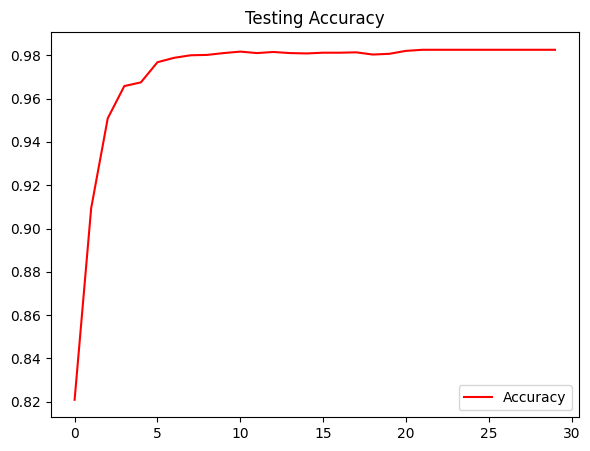

<Figure size 1500x500 with 0 Axes>

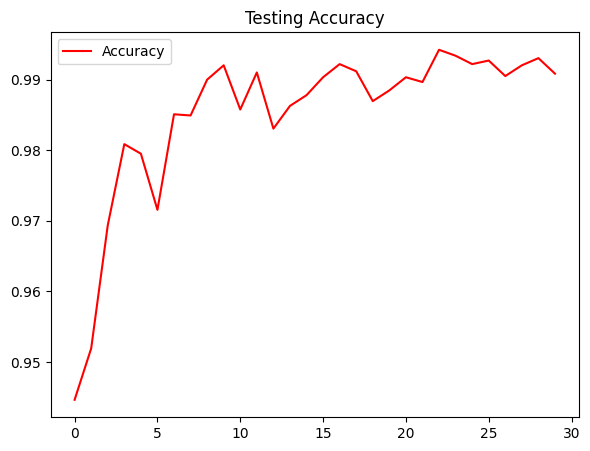

<Figure size 1500x500 with 0 Axes>

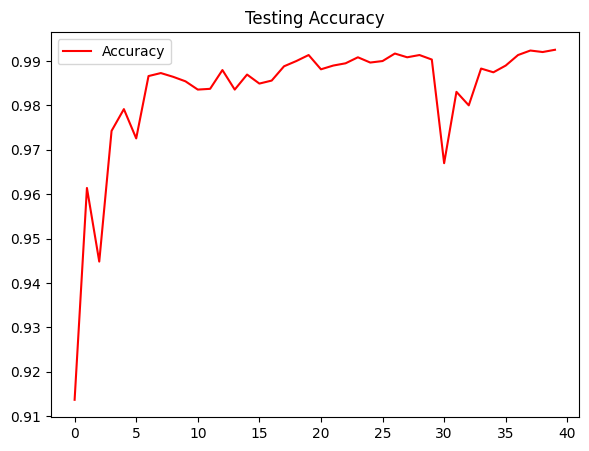

<Figure size 1500x500 with 0 Axes>

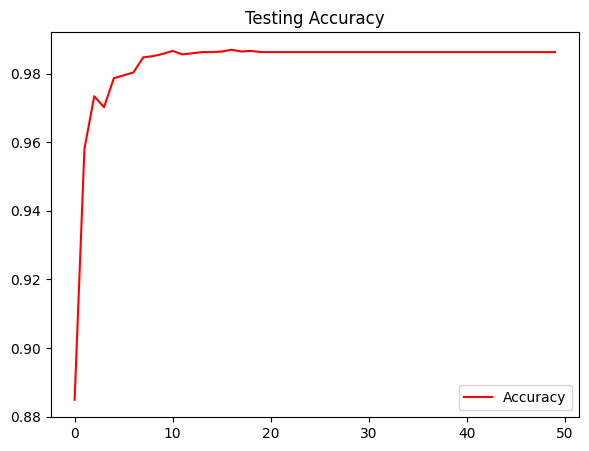

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

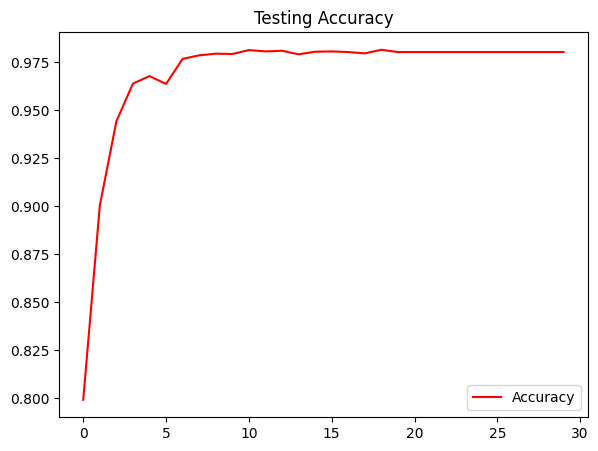

<Figure size 1500x500 with 0 Axes>

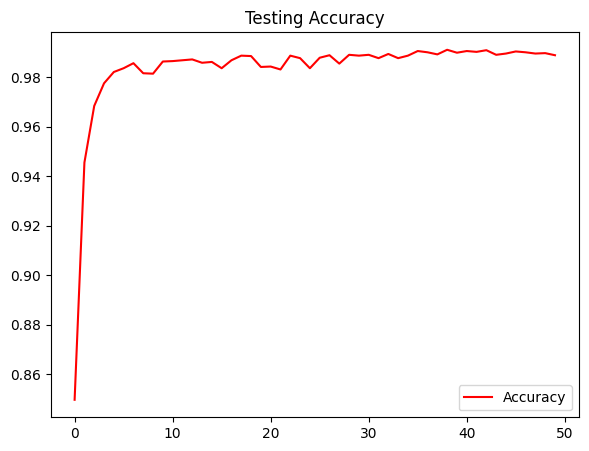

<Figure size 1500x500 with 0 Axes>

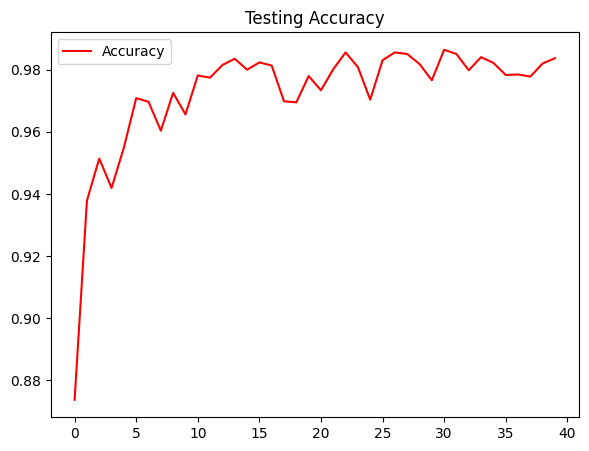

<Figure size 1500x500 with 0 Axes>

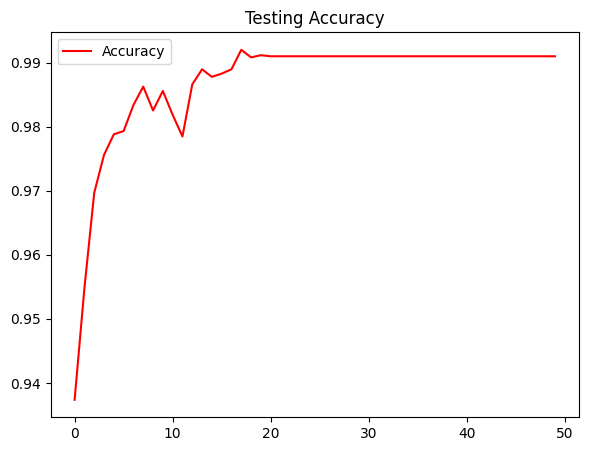

<Figure size 1500x500 with 0 Axes>

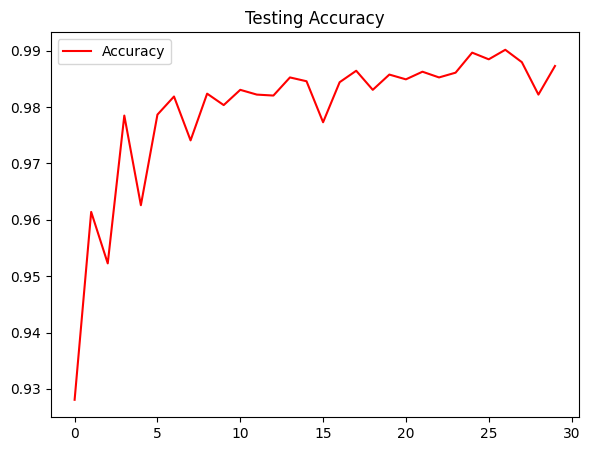

<Figure size 1500x500 with 0 Axes>

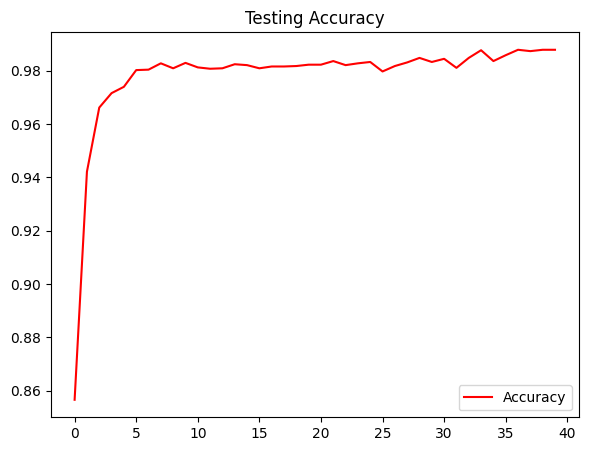

<Figure size 1500x500 with 0 Axes>

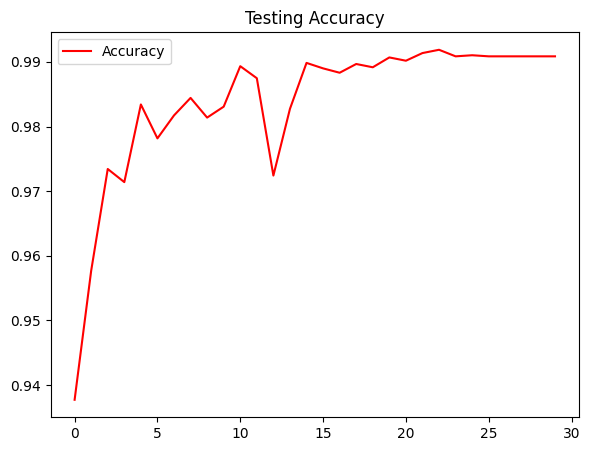

<Figure size 1500x500 with 0 Axes>

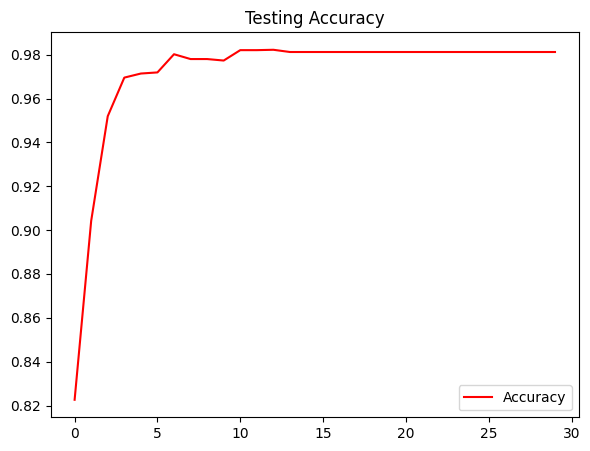

<Figure size 1500x500 with 0 Axes>

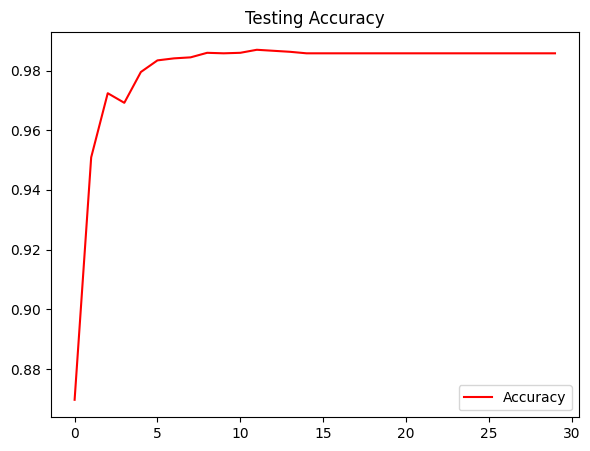

<Figure size 1500x500 with 0 Axes>

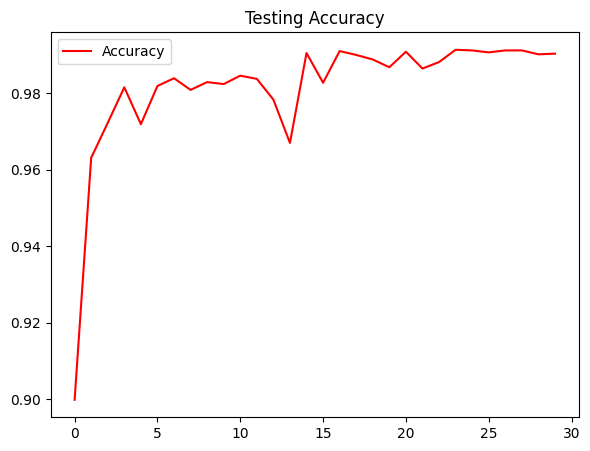

<Figure size 1500x500 with 0 Axes>

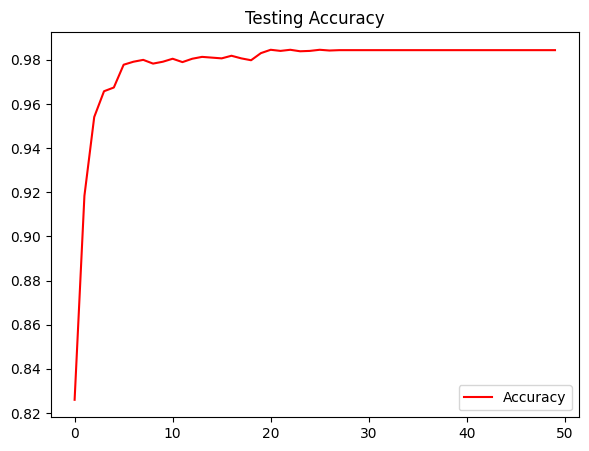

<Figure size 1500x500 with 0 Axes>

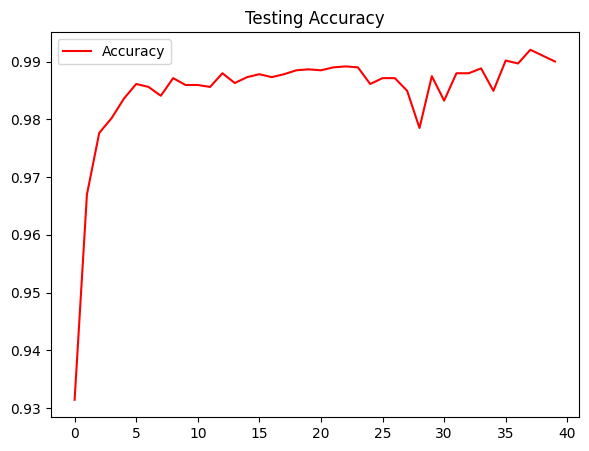

<Figure size 1500x500 with 0 Axes>

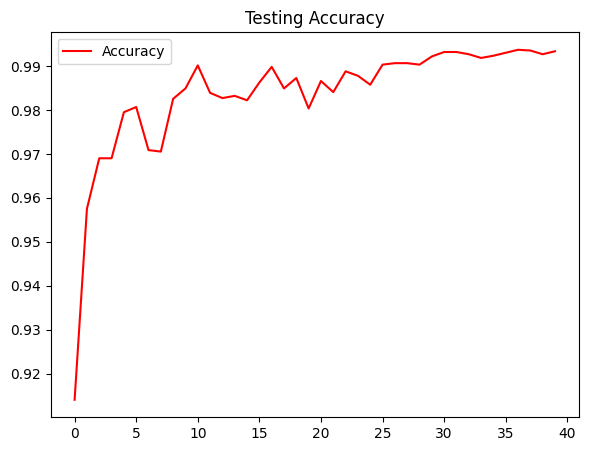

<Figure size 1500x500 with 0 Axes>

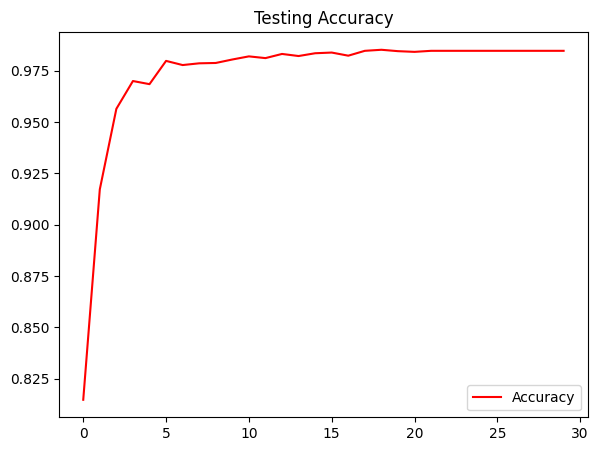

<Figure size 1500x500 with 0 Axes>

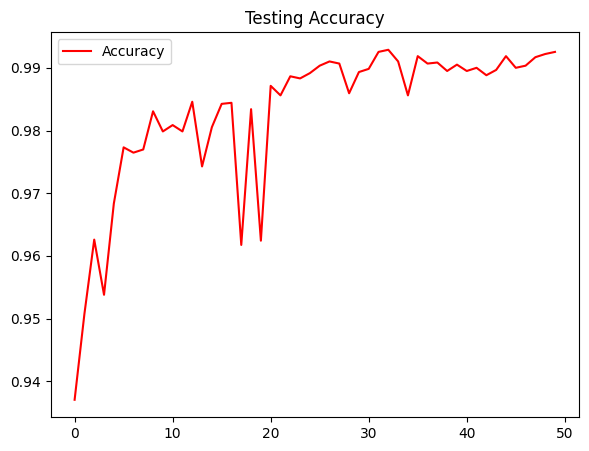

<Figure size 1500x500 with 0 Axes>

In [24]:
# Select to maximize or minimize parameters
study = optuna.create_study(directions=['maximize', 'maximize'], storage=f"sqlite:///{os.path.join(HOME, 'data', 'siamese.db')}", load_if_exists=True)
study.optimize(objective, n_trials=20)

In [ ]:
# Save the parameters
import pickle

# save the list to a file
with open(os.path.join(HOME, 'data', 'siamese.db', 'trials.pickle'), 'wb') as f:
    pickle.dump(study.best_trials, f)

In [ ]:
### Test on video output

# correct_list = []
# incrrect_list = []

# for filename in os.listdir(os.path.join(HOME, 'SIAMESE_TEST_DATA')):
#     image_path = os.path.join(HOME, 'SIAMESE_TEST_DATA', filename)
#     byte_img = tf.io.read_file(image_path)
#     img = tf.io.decode_jpeg(byte_img)
    
#     best = DETECTION_THRESHOLD
#     cow = "None"
#     for image in os.listdir(os.path.join(HOME, 'db')):
#         byte_img = tf.io.read_file(os.path.join(HOME, 'db', image))
#         db_img = tf.io.decode_jpeg(byte_img)
        
#         input_img = preprocess(img)
#         validation_img = preprocess(db_img)
        
#         # Make Predictions 
#         distance = classify_image(encoder, input_img, validation_img)
#         if distance < DETECTION_THRESHOLD and distance < best:
#             best = distance
#             cow = image
#     if cow != "None" and :
